# Ready

## Import library

In [ ]:
!pip install -q scikit-plot

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import dlib
import urllib

from google.colab import drive
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import scikitplot as skplt

from skimage import feature

import pickle
import joblib

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dir_dataset = '/content/drive/MyDrive/PYTHON/CV/DoAn/Dataset'

## Load data from csv

In [ ]:
df_train = pd.read_csv(os.path.join(dir_dataset, 'csv', 'train.csv'))
df_test = pd.read_csv(os.path.join(dir_dataset, 'csv', 'test.csv'))

In [ ]:
lb_encoder = LabelEncoder()
lb_encoder.fit(df_train['label'])

df_train['label'] = lb_encoder.transform(df_train['label'])
df_test['label'] = lb_encoder.fit_transform(df_test['label'])

In [ ]:
df_train['images'] = [np.array([int(value) for value in img.split(' ')], dtype='uint8').reshape(48, 48) for img in df_train['images']]
df_test['images'] = [np.array([int(value) for value in img.split(' ')], dtype='uint8').reshape(48, 48) for img in df_test['images']]

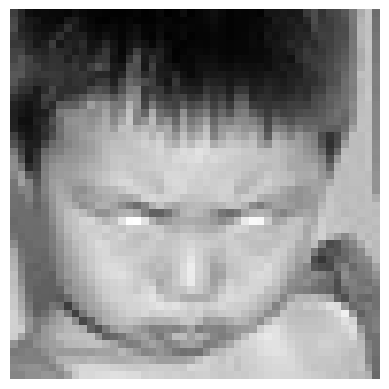

In [ ]:
plt.axis("off")
plt.imshow(df_train['images'][0], cmap='gray')

## Keypoint (Harris)

In [ ]:
def harris(img, threshold):

  # modify the data type setting to 32-bit floating point
  mask = np.float32(gray)
  # apply the cv2.cornerHarris method to detect the corners
  corners = cv2.cornerHarris(img, 2, 3, 0.05)
  #result is dilated for marking the corners
  corners = cv2.dilate(corners, None)

  mask[True] = 1
  mask[corners > threshold * corners.max()]= 0

  return mask

In [ ]:
threshold = 0.04

gray = df_train['images'][0]

gray = np.float32(gray)
mask = gray.copy()

corners = cv2.cornerHarris(gray, 2, 3, 0.05)
corners = cv2.dilate(corners, None)

mask[True] = 255
mask[corners > threshold * corners.max()]= 0

(-0.5, 47.5, 47.5, -0.5)

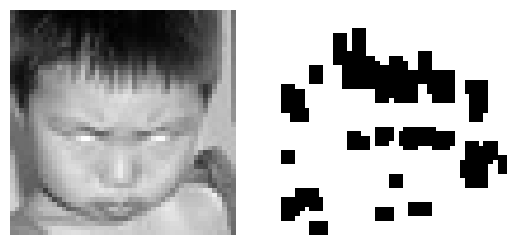

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(gray, cmap='gray')
ax1.axis('off')

ax2.imshow(mask, cmap='gray')
ax2.axis('off')

In [ ]:
threshold = 0.04

df_train_kp = pd.DataFrame(columns=['label', 'keypoint'])
for index in range(len(df_train)):
  img = df_train['images'][index]
  label = df_train['label'][index]

  keypoint = harris(img, threshold)
  df_train_kp.loc[len(df_train_kp)] = (label, keypoint)

In [ ]:
df_train_kp.head()

,label,keypoint
0,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [ ]:
threshold = 0.04

df_test_kp = pd.DataFrame(columns=['label', 'keypoint'])
for index in range(len(df_test)):
  img = df_test['images'][index]
  label = df_test['label'][index]

  keypoint = harris(img, threshold)
  df_test_kp.loc[len(df_test_kp)] = (label, keypoint)

In [ ]:
df_test_kp.head()

,label,keypoint
0,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


## HOG

In [ ]:
img = df_train['images'][0]
hog, hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True)

(-0.5, 47.5, 47.5, -0.5)

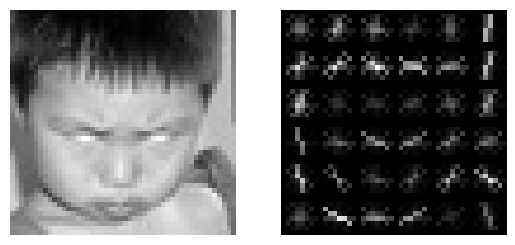

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(img, cmap='gray')
ax1.axis('off')

ax2.imshow(hog_img, cmap='gray')
ax2.axis('off')

In [ ]:
df_train_hog = pd.DataFrame(columns=['label', 'hog'])
for index in range(len(df_train)):
  img = df_train['images'][index]
  label = df_train['label'][index]

  hog, _ = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True)
  df_train_hog.loc[len(df_train_hog)] = (label, hog)

In [ ]:
df_train_hog.head()

,label,hog
0,0,"[0.18819581368589164, 0.08610873635217364, 0.2..."
1,0,"[0.28730767537249075, 0.10333819890812801, 0.0..."
2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,"[0.27006356979932405, 0.23225932270346225, 0.2..."
4,0,"[0.028658503892556395, 0.006714289702601121, 0..."


In [ ]:
df_test_hog = pd.DataFrame(columns=['label', 'hog'])
for index in range(len(df_test)):
  img = df_test['images'][index]
  label = df_test['label'][index]

  hog, _ = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True)
  df_test_hog.loc[len(df_test_hog)] = (label, hog)

In [ ]:
df_test_hog.head()

,label,hog
0,0,"[0.20650510306626785, 0.1695636863040359, 0.13..."
1,0,"[0.23926231609135415, 0.04453442164376673, 0.2..."
2,0,"[0.2861950661308298, 0.04552025133072528, 0.0,..."
3,0,"[0.01934276585556256, 0.0, 0.00901246198014773..."
4,0,"[0.11485116698609653, 0.03626449948182972, 0.0..."


## Data mining

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(np.array([img for img in df_train['images'].values]), df_train['label'].values, test_size=1/8, stratify=df_train['label'].values)

X_test = np.array([img for img in df_test['images'].values])
y_test = df_test['label'].values

In [ ]:
X_train_hog, X_val_hog, y_train_hog, y_val_hog = train_test_split(np.array([hog for hog in df_train_hog['hog'].values]), df_train_hog['label'].values, test_size=1/8, stratify=df_train_hog['label'].values)

X_test_hog = np.array([hog for hog in df_test_hog['hog'].values])
y_test_hog = df_test_hog['label'].values

In [ ]:
X_train_kp, X_val_kp, y_train_kp, y_val_kp = train_test_split(np.array([kp for kp in df_train_kp['keypoint'].values]), df_train_kp['label'].values, test_size=1/8, stratify=df_train_kp['label'].values)

X_test_kp = np.array([kp for kp in df_test_kp['keypoint'].values])
y_test_kp = df_test_kp['label'].values

In [ ]:
CountLabel_train = np.zeros(7, dtype='uint64')
CountLabel_val = np.zeros(7, dtype='uint64')
CountLabel_test = np.zeros(7, dtype='uint64')

for label in y_train:
  CountLabel_train[label] += 1

for label in y_val:
  CountLabel_val[label] += 1

for label in y_test:
  CountLabel_test[label] += 1

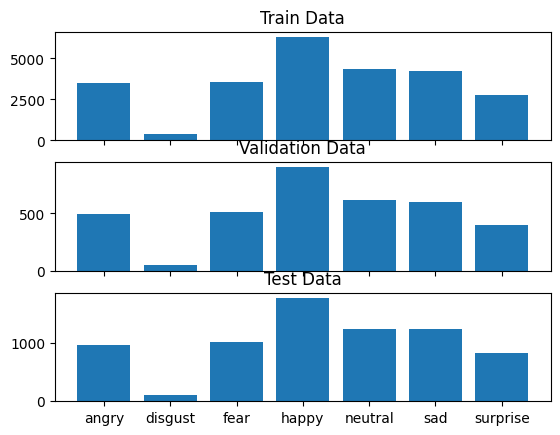

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.bar(lb_encoder.inverse_transform(range(7)), CountLabel_train)
ax1.title.set_text('Train Data')

ax2.bar(lb_encoder.inverse_transform(range(7)), CountLabel_val)
ax2.title.set_text('Validation Data')

ax3.bar(lb_encoder.inverse_transform(range(7)), CountLabel_test)
ax3.title.set_text('Test Data')

plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/train_val_test_dis.png')

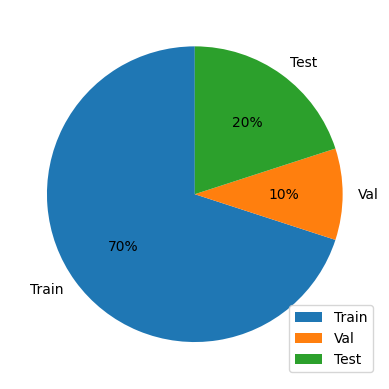

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(y_train), len(y_val), len(y_test)], labels=['Train', 'Val', 'Test'], startangle=90, autopct='%1.0f%%')
plt.legend(loc='lower right')

plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/dataset_dis.png')

## Data Pre-processing

In [ ]:
# Normalize
X_train = np.array([[[x/255 for x in row] for row in img] for img in X_train])
X_val = np.array([[[x/255 for x in row] for row in img] for img in X_val])
X_test = np.array([[[x/255 for x in row] for row in img] for img in X_test])

#### Ready for torch

In [ ]:
# Convert to Tensor
X_train_tensor = torch.from_numpy(X_train.reshape(X_train.shape[0], 1, 48, 48)).float()
X_val_tensor = torch.from_numpy(X_val.reshape(X_val.shape[0], 1, 48, 48)).float()
X_test_tensor = torch.from_numpy(X_test.reshape(X_test.shape[0], 1, 48, 48)).float()

y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)
y_test_tensor = torch.from_numpy(y_test)


X_train_hog_tensor = torch.from_numpy(X_train_hog).float()
X_val_hog_tensor = torch.from_numpy(X_val_hog).float()
X_test_hog_tensor = torch.from_numpy(X_test_hog).float()

y_train_hog_tensor = torch.from_numpy(y_train_hog)
y_val_hog_tensor = torch.from_numpy(y_val_hog)
y_test_hog_tensor = torch.from_numpy(y_test_hog)

X_train_kp_tensor = torch.from_numpy(X_train_kp).float()
X_val_kp_tensor = torch.from_numpy(X_val_kp).float()
X_test_kp_tensor = torch.from_numpy(X_test_kp).float()

y_train_kp_tensor = torch.from_numpy(y_train_kp)
y_val_kp_tensor = torch.from_numpy(y_val_kp)
y_test_kp_tensor = torch.from_numpy(y_test_kp)

In [ ]:
# Convert to Tensor Dataset
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
val_tensor = TensorDataset(X_val_tensor, y_val_tensor)
test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

train_hog_tensor = TensorDataset(X_train_hog_tensor, y_train_hog_tensor)
val_hog_tensor = TensorDataset(X_val_hog_tensor, y_val_hog_tensor)
test_hog_tensor = TensorDataset(X_test_hog_tensor, y_test_hog_tensor)

train_kp_tensor = TensorDataset(X_train_kp_tensor, y_train_kp_tensor)
val_kp_tensor = TensorDataset(X_val_kp_tensor, y_val_kp_tensor)
test_kp_tensor = TensorDataset(X_test_kp_tensor, y_test_kp_tensor)

In [ ]:
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
val_loader = DataLoader(val_tensor)
test_loader = DataLoader(test_tensor)

train_hog_loader = DataLoader(train_hog_tensor, batch_size=64, shuffle=True)
val_hog_loader = DataLoader(val_hog_tensor)
test_hog_loader = DataLoader(test_hog_tensor)

train_kp_loader = DataLoader(train_kp_tensor, batch_size=64, shuffle=True)
val_kp_loader = DataLoader(val_kp_tensor)
test_kp_loader = DataLoader(test_kp_tensor)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Models


## ML models

### K-nearest neighbours

#### Image

##### Euclidean

In [ ]:
score_per_K_value = []
for i in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
  knn.fit(X_train.reshape(X_train.shape[0], -1), y_train)

  y_val_pred = knn.predict(X_val.reshape(X_val.shape[0], -1))
  score_per_K_value.append(f1_score(y_val, y_val_pred, average='micro'))

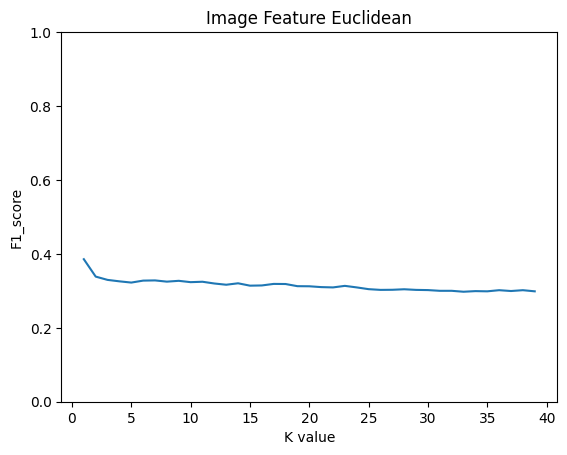

In [ ]:
plt.plot(range(1, len(score_per_K_value)+1), score_per_K_value)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Image Feature Euclidean')
plt.ylim(0, 1)

# Save fig
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/knn_image_feature_euc.png')
# Save score_per_K_value
pickle.dump(score_per_K_value, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_image_euc.pkl', 'wb'))

In [ ]:
n_neighbors = 0
for i in range(len(score_per_K_value)):
  if score_per_K_value[i] == max(score_per_K_value):
    n_neighbors = i+1
    break
print(n_neighbors)

1


In [ ]:
knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
knn.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Save model
pickle.dump(knn, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_image_euc.pkl', 'wb'))

##### Cosine

In [ ]:
score_per_K_value = []
for i in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors=i, metric='cosine')
  knn.fit(X_train.reshape(X_train.shape[0], -1), y_train)

  y_val_pred = knn.predict(X_val.reshape(X_val.shape[0], -1))
  score_per_K_value.append(f1_score(y_val, y_val_pred, average='micro'))

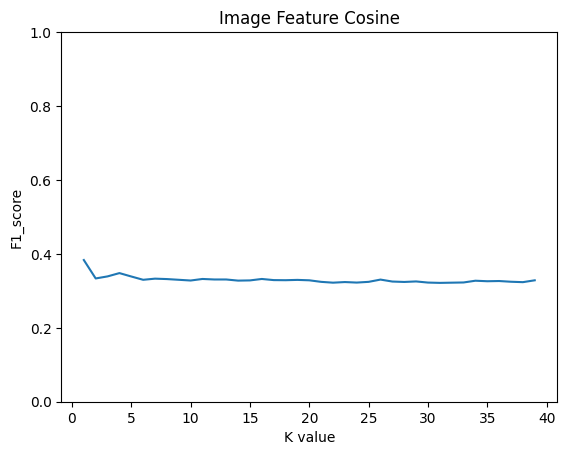

In [ ]:
plt.plot(range(1, len(score_per_K_value)+1), score_per_K_value)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Image Feature Cosine')
plt.ylim(0, 1)

# Save fig
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/knn_image_feature_cos.png')
# Save score_per_K_value
pickle.dump(score_per_K_value, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_image_cos.pkl', 'wb'))

In [ ]:
n_neighbors = 0
for i in range(len(score_per_K_value)):
  if score_per_K_value[i] == max(score_per_K_value):
    n_neighbors = i+1
    break
print(n_neighbors)

1


In [ ]:
knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
knn.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Save model
pickle.dump(knn, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_image_cos.pkl', 'wb'))

#### Hog

##### Euclidean

In [ ]:
score_per_K_value_hog = []
for i in range(1, 40):
  knn_hog = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
  knn_hog.fit(X_train_hog, y_train_hog)

  y_val_pred = knn_hog.predict(X_val_hog)
  score_per_K_value_hog.append(f1_score(y_val_hog, y_val_pred, average='micro'))

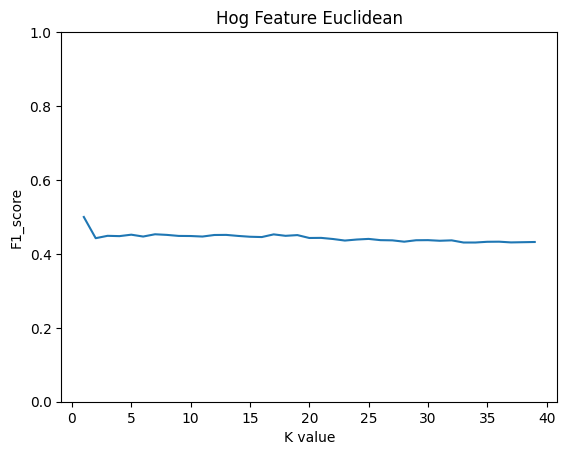

In [ ]:
plt.plot(range(1, len(score_per_K_value_hog)+1), score_per_K_value_hog)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Hog Feature Euclidean')
plt.ylim(0, 1)

# Save fig
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/knn_hog_feature_euc.png')
# Save score_per_K_value_hog
pickle.dump(score_per_K_value_hog, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_hog_euc.pkl', 'wb'))

In [ ]:
n_neighbors = 0
for i in range(len(score_per_K_value_hog)):
  if score_per_K_value_hog[i] == max(score_per_K_value_hog):
    n_neighbors = i+1
    break
print(n_neighbors)

1


In [ ]:
knn_hog = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
knn_hog.fit(X_train_hog, y_train_hog)

# Save model
pickle.dump(knn_hog, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_hog_euc.pkl', 'wb'))

##### Cosine

In [ ]:
score_per_K_value_hog = []
for i in range(1, 40):
  knn_hog = KNeighborsClassifier(n_neighbors=i, metric='cosine')
  knn_hog.fit(X_train_hog, y_train_hog)

  y_val_pred = knn_hog.predict(X_val_hog)
  score_per_K_value_hog.append(f1_score(y_val_hog, y_val_pred, average='micro'))

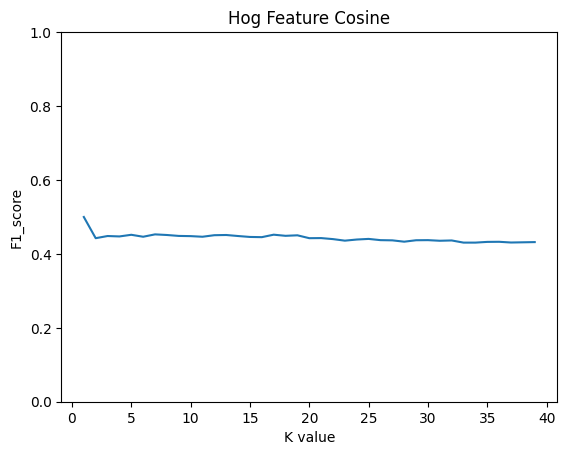

In [ ]:
plt.plot(range(1, len(score_per_K_value_hog)+1), score_per_K_value_hog)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Hog Feature Cosine')
plt.ylim(0, 1)

# Save fig
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/knn_hog_feature_cos.png')
# Save score_per_K_value_hog
pickle.dump(score_per_K_value_hog, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_hog_cos.pkl', 'wb'))

In [ ]:
n_neighbors = 0
for i in range(len(score_per_K_value_hog)):
  if score_per_K_value_hog[i] == max(score_per_K_value_hog):
    n_neighbors = i+1
    break
print(n_neighbors)

1


In [ ]:
knn_hog = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
knn_hog.fit(X_train_hog, y_train_hog)

# Save model
pickle.dump(knn_hog, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_hog_cos.pkl', 'wb'))

#### Keypoint

##### Euclidean

In [ ]:
score_per_K_value_kp = []
for i in range(1, 40):
  knn_kp = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
  knn_kp.fit(X_train_kp.reshape(X_train_kp.shape[0], -1), y_train_kp)

  y_val_pred = knn_kp.predict(X_val_kp.reshape(X_val_kp.shape[0], -1))
  score_per_K_value_kp.append(f1_score(y_val_kp, y_val_pred, average='micro'))

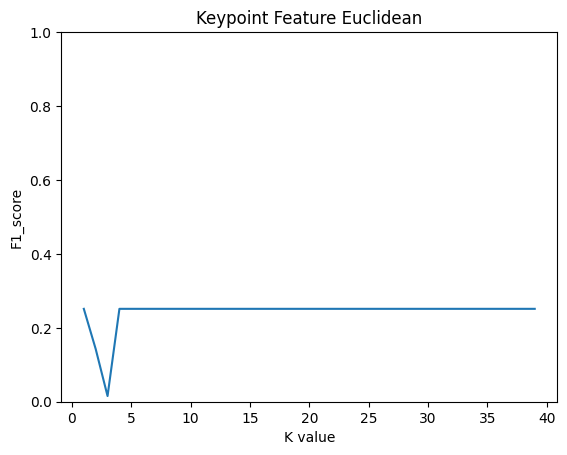

In [ ]:
plt.plot(range(1, len(score_per_K_value_kp)+1), score_per_K_value_kp)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Keypoint Feature Euclidean')
plt.ylim(0, 1)

# Save fig
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/knn_kp_feature_euc.png')
# Save score_per_K_value_hog
pickle.dump(score_per_K_value_kp, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_kp_euc.pkl', 'wb'))

In [ ]:
n_neighbors = 0
for i in range(len(score_per_K_value_kp)):
  if score_per_K_value_kp[i] == max(score_per_K_value_kp):
    n_neighbors = i+1
    break
print(n_neighbors)

1


In [ ]:
knn_kp = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
knn_kp.fit(X_train_kp.reshape(X_train.shape[0], -1), y_train)

# Save model
pickle.dump(knn_kp, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_kp_euc.pkl', 'wb'))

##### Cosine

In [ ]:
score_per_K_value_kp = []
for i in range(1, 40):
  knn_kp = KNeighborsClassifier(n_neighbors=i, metric='cosine')
  knn_kp.fit(X_train_kp.reshape(X_train_kp.shape[0], -1), y_train_kp)

  y_val_pred = knn_kp.predict(X_val_kp.reshape(X_val_kp.shape[0], -1))
  score_per_K_value_kp.append(f1_score(y_val_kp, y_val_pred, average='micro'))

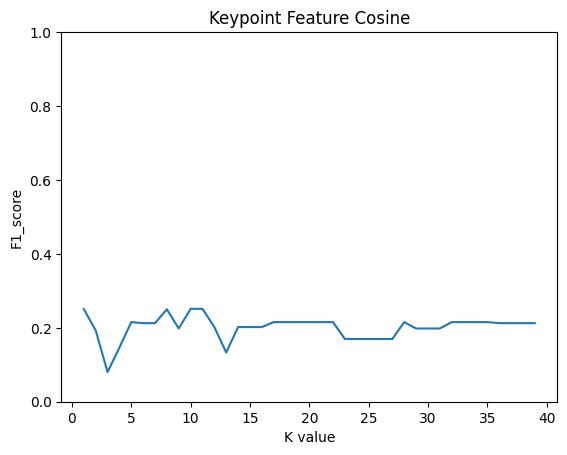

In [ ]:
plt.plot(range(1, len(score_per_K_value_kp)+1), score_per_K_value_kp)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Keypoint Feature Cosine')
plt.ylim(0, 1)

# Save fig
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/knn_kp_feature_cos.png')
# Save score_per_K_value_hog
pickle.dump(score_per_K_value_kp, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_kp_cos.pkl', 'wb'))

In [ ]:
n_neighbors = 0
for i in range(len(score_per_K_value_kp)):
  if score_per_K_value_kp[i] == max(score_per_K_value_kp):
    n_neighbors = i+1
    break
print(n_neighbors)

10


In [ ]:
knn_kp = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
knn_kp.fit(X_train_kp.reshape(X_train.shape[0], -1), y_train)

# Save model
pickle.dump(knn_kp, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_kp_cos.pkl', 'wb'))

### SVM

#### Image

In [ ]:
svm = LinearSVC()
svm.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Save model
pickle.dump(svm, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/svm_image.pkl', 'wb'))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### HOG

In [ ]:
svm_hog = LinearSVC()
svm_hog.fit(X_train_hog, y_train_hog)

# Save model
pickle.dump(svm_hog, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/svm_hog.pkl', 'wb'))

#### Keypoint

In [ ]:
svm_kp = LinearSVC()
svm_kp.fit(X_train_kp.reshape(X_train_kp.shape[0], -1), y_train_kp)

# Save model
pickle.dump(svm_kp, open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/svm_kp.pkl', 'wb'))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## DL models

### Multi-layer perceptrons

In [ ]:
def model_evaluation_mlp(data_loader, model):
  label = []
  label_pred = []
  model.eval()

  with torch.no_grad():
    for (imgs, labels) in data_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      imgs = imgs.reshape(imgs.shape[0], -1)

      #forward
      _, probs = model(imgs)
      _, y_pred = probs.max(1)

      for i in range(len(labels)):
        label.append(labels[i].item())
        label_pred.append(y_pred[i].item())

  return f1_score(label, label_pred, average='micro')

In [ ]:
def train_model_mlp(train_loader, val_loader, model, init_lr, maxEpoch):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=init_lr)

  loss_each_epoch = []
  score_train_each_epoch = []
  score_val_each_epoch = []

  model.train()

  for epoch in range(maxEpoch):
    sum_loss = 0.0
    for (imgs, labels) in train_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      imgs = imgs.reshape(imgs.shape[0], -1)

      logits, _ = model(imgs)
      loss = criterion(logits, labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward() # Compute gradient

      optimizer.step() # Update model's parameters

      sum_loss += loss.item()
    loss_each_epoch.append(sum_loss / len(train_loader.dataset))
    score_train_each_epoch.append(model_evaluation_mlp(train_loader, model))
    score_val_each_epoch.append(model_evaluation_mlp(val_loader, model))
    print(f'Epoch {epoch +1}/{maxEpoch},\t Loss: {loss_each_epoch[-1]:.5f},\t\t F1_test: {score_train_each_epoch[-1]:.2f},\t F1_val: {score_val_each_epoch[-1]:.2f}')
  return loss_each_epoch, score_train_each_epoch, score_val_each_epoch, optimizer

In [ ]:
def plotLoss(loss_each_epoch, score_train_each_epoch, score_val_each_epoch):
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

  ax1.plot(range(1, len(loss_each_epoch)+1), loss_each_epoch)
  ax1.set_title('Loss')

  ax2.plot(range(1, len(score_train_each_epoch)+1), score_train_each_epoch, label='train')
  ax2.plot(range(1, len(score_val_each_epoch)+1), score_val_each_epoch, label='validation')
  ax2.set_title('F1 Score')

  plt.xlabel('Epoch')
  plt.legend()

#### Mean

##### Image

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden_node):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, n_hidden_node),
            nn.ReLU(),
            nn.Linear(n_hidden_node, output_dim)
        )

    def forward(self, x):
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
mlp_mean = MLP(48*48, 7, math.floor((48*48+7)/2)).to(device)
mlp_mean

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1155, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1155, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_mean, score_train_each_epoch_mlp_mean, score_val_each_epoch_mlp_mean, optimizer_mlp_mean = train_model_mlp(train_loader, val_loader, mlp_mean, 0.001, 100)

Epoch 1/100,	 Loss: 0.02814,		 F1_test: 0.33,	 F1_val: 0.31
Epoch 2/100,	 Loss: 0.02675,		 F1_test: 0.33,	 F1_val: 0.32
Epoch 3/100,	 Loss: 0.02636,		 F1_test: 0.36,	 F1_val: 0.35
Epoch 4/100,	 Loss: 0.02602,		 F1_test: 0.35,	 F1_val: 0.34
Epoch 5/100,	 Loss: 0.02569,		 F1_test: 0.35,	 F1_val: 0.34
Epoch 6/100,	 Loss: 0.02552,		 F1_test: 0.38,	 F1_val: 0.36
Epoch 7/100,	 Loss: 0.02535,		 F1_test: 0.36,	 F1_val: 0.34
Epoch 8/100,	 Loss: 0.02512,		 F1_test: 0.38,	 F1_val: 0.35
Epoch 9/100,	 Loss: 0.02503,		 F1_test: 0.36,	 F1_val: 0.34
Epoch 10/100,	 Loss: 0.02486,		 F1_test: 0.39,	 F1_val: 0.37
Epoch 11/100,	 Loss: 0.02472,		 F1_test: 0.40,	 F1_val: 0.37
Epoch 12/100,	 Loss: 0.02460,		 F1_test: 0.40,	 F1_val: 0.36
Epoch 13/100,	 Loss: 0.02448,		 F1_test: 0.39,	 F1_val: 0.36
Epoch 14/100,	 Loss: 0.02438,		 F1_test: 0.41,	 F1_val: 0.38
Epoch 15/100,	 Loss: 0.02414,		 F1_test: 0.40,	 F1_val: 0.37
Epoch 16/100,	 Loss: 0.02413,		 F1_test: 0.41,	 F1_val: 0.37
Epoch 17/100,	 Loss: 0.02401,		 F

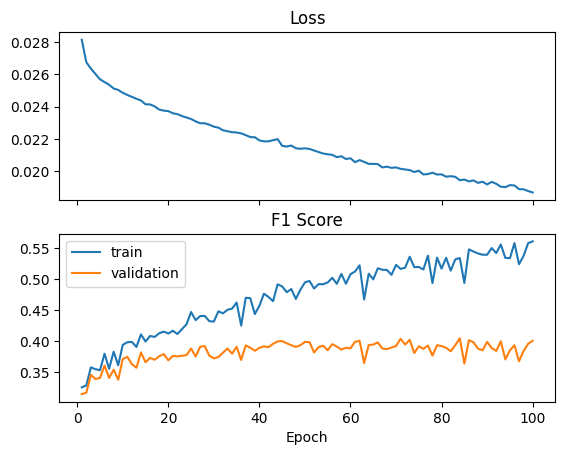

In [ ]:
plotLoss(loss_each_epoch_mlp_mean, score_train_each_epoch_mlp_mean, score_val_each_epoch_mlp_mean)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/mlp_mean_image.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_mean)):
  if score_val_each_epoch_mlp_mean[index] == max(score_val_each_epoch_mlp_mean):
    n_epoch = index + 1
    break
print(n_epoch)

84


In [ ]:
mlp_mean = MLP(48*48, 7, math.floor((48*48+7)/2)).to(device)
mlp_mean

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1155, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1155, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_mean, score_train_each_epoch_mlp_mean, score_val_each_epoch_mlp_mean, optimizer_mlp_mean = train_model_mlp(train_loader, val_loader, mlp_mean, 0.001, n_epoch)

Epoch 1/84,	 Loss: 0.02812,		 F1_test: 0.32,	 F1_val: 0.31
Epoch 2/84,	 Loss: 0.02672,		 F1_test: 0.31,	 F1_val: 0.31
Epoch 3/84,	 Loss: 0.02625,		 F1_test: 0.34,	 F1_val: 0.32
Epoch 4/84,	 Loss: 0.02608,		 F1_test: 0.36,	 F1_val: 0.34
Epoch 5/84,	 Loss: 0.02565,		 F1_test: 0.37,	 F1_val: 0.35
Epoch 6/84,	 Loss: 0.02546,		 F1_test: 0.38,	 F1_val: 0.35
Epoch 7/84,	 Loss: 0.02521,		 F1_test: 0.38,	 F1_val: 0.36
Epoch 8/84,	 Loss: 0.02505,		 F1_test: 0.37,	 F1_val: 0.35
Epoch 9/84,	 Loss: 0.02486,		 F1_test: 0.37,	 F1_val: 0.35
Epoch 10/84,	 Loss: 0.02467,		 F1_test: 0.39,	 F1_val: 0.37
Epoch 11/84,	 Loss: 0.02445,		 F1_test: 0.39,	 F1_val: 0.36
Epoch 12/84,	 Loss: 0.02441,		 F1_test: 0.41,	 F1_val: 0.37
Epoch 13/84,	 Loss: 0.02422,		 F1_test: 0.41,	 F1_val: 0.37
Epoch 14/84,	 Loss: 0.02415,		 F1_test: 0.40,	 F1_val: 0.37
Epoch 15/84,	 Loss: 0.02402,		 F1_test: 0.41,	 F1_val: 0.38
Epoch 16/84,	 Loss: 0.02389,		 F1_test: 0.42,	 F1_val: 0.38
Epoch 17/84,	 Loss: 0.02372,		 F1_test: 0.41,	 F1

In [ ]:
print('In the test set:')
model_evaluation_mlp(test_loader, mlp_mean)

In the test set:


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_mean.state_dict(),
            'optimizer_state_dict': optimizer_mlp_mean.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_mean,
            'score_train_each_epoch': score_train_each_epoch_mlp_mean,
            'score_val_each_epoch': score_val_each_epoch_mlp_mean,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_mean.pt')

##### HOG

In [ ]:
mlp_mean_hog = MLP(900, 7, math.floor((900+7)/2)).to(device)
mlp_mean_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=453, bias=True)
    (1): ReLU()
    (2): Linear(in_features=453, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_mean_hog, score_train_each_epoch_mlp_mean_hog, score_val_each_epoch_mlp_mean_hog, optimizer_mlp_mean_hog = train_model_mlp(train_hog_loader, val_hog_loader, mlp_mean_hog, 0.001, 100)

Epoch 1/100,	 Loss: 0.02458,		 F1_test: 0.41,	 F1_val: 0.40
Epoch 2/100,	 Loss: 0.02286,		 F1_test: 0.45,	 F1_val: 0.43
Epoch 3/100,	 Loss: 0.02235,		 F1_test: 0.45,	 F1_val: 0.44
Epoch 4/100,	 Loss: 0.02185,		 F1_test: 0.47,	 F1_val: 0.46
Epoch 5/100,	 Loss: 0.02144,		 F1_test: 0.47,	 F1_val: 0.44
Epoch 6/100,	 Loss: 0.02103,		 F1_test: 0.50,	 F1_val: 0.47
Epoch 7/100,	 Loss: 0.02063,		 F1_test: 0.51,	 F1_val: 0.47
Epoch 8/100,	 Loss: 0.02018,		 F1_test: 0.52,	 F1_val: 0.47
Epoch 9/100,	 Loss: 0.01966,		 F1_test: 0.54,	 F1_val: 0.48
Epoch 10/100,	 Loss: 0.01914,		 F1_test: 0.54,	 F1_val: 0.48
Epoch 11/100,	 Loss: 0.01873,		 F1_test: 0.56,	 F1_val: 0.48
Epoch 12/100,	 Loss: 0.01823,		 F1_test: 0.59,	 F1_val: 0.49
Epoch 13/100,	 Loss: 0.01768,		 F1_test: 0.59,	 F1_val: 0.49
Epoch 14/100,	 Loss: 0.01724,		 F1_test: 0.60,	 F1_val: 0.48
Epoch 15/100,	 Loss: 0.01676,		 F1_test: 0.62,	 F1_val: 0.49
Epoch 16/100,	 Loss: 0.01619,		 F1_test: 0.65,	 F1_val: 0.50
Epoch 17/100,	 Loss: 0.01566,		 F

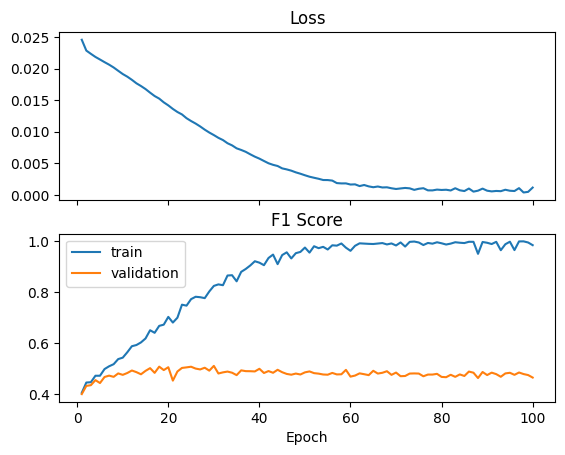

In [ ]:
plotLoss(loss_each_epoch_mlp_mean_hog, score_train_each_epoch_mlp_mean_hog, score_val_each_epoch_mlp_mean_hog)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/mlp_mean_hog.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_mean_hog)):
  if score_val_each_epoch_mlp_mean_hog[index] == max(score_val_each_epoch_mlp_mean_hog):
    n_epoch = index + 1
    break
print(n_epoch)

30


In [ ]:
mlp_mean_hog = MLP(900, 7, math.floor((900+7)/2)).to(device)
mlp_mean_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=453, bias=True)
    (1): ReLU()
    (2): Linear(in_features=453, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_mean_hog, score_train_each_epoch_mlp_mean_hog, score_val_each_epoch_mlp_mean_hog, optimizer_mlp_mean_hog = train_model_mlp(train_hog_loader, val_hog_loader, mlp_mean_hog, 0.001, n_epoch)

Epoch 1/30,	 Loss: 0.02468,		 F1_test: 0.44,	 F1_val: 0.44
Epoch 2/30,	 Loss: 0.02294,		 F1_test: 0.44,	 F1_val: 0.44
Epoch 3/30,	 Loss: 0.02233,		 F1_test: 0.46,	 F1_val: 0.44
Epoch 4/30,	 Loss: 0.02190,		 F1_test: 0.48,	 F1_val: 0.45
Epoch 5/30,	 Loss: 0.02145,		 F1_test: 0.48,	 F1_val: 0.46
Epoch 6/30,	 Loss: 0.02103,		 F1_test: 0.48,	 F1_val: 0.46
Epoch 7/30,	 Loss: 0.02069,		 F1_test: 0.51,	 F1_val: 0.48
Epoch 8/30,	 Loss: 0.02017,		 F1_test: 0.52,	 F1_val: 0.48
Epoch 9/30,	 Loss: 0.01968,		 F1_test: 0.54,	 F1_val: 0.48
Epoch 10/30,	 Loss: 0.01920,		 F1_test: 0.56,	 F1_val: 0.47
Epoch 11/30,	 Loss: 0.01877,		 F1_test: 0.56,	 F1_val: 0.48
Epoch 12/30,	 Loss: 0.01828,		 F1_test: 0.58,	 F1_val: 0.48
Epoch 13/30,	 Loss: 0.01777,		 F1_test: 0.60,	 F1_val: 0.48
Epoch 14/30,	 Loss: 0.01726,		 F1_test: 0.61,	 F1_val: 0.49
Epoch 15/30,	 Loss: 0.01679,		 F1_test: 0.63,	 F1_val: 0.50
Epoch 16/30,	 Loss: 0.01622,		 F1_test: 0.64,	 F1_val: 0.49
Epoch 17/30,	 Loss: 0.01572,		 F1_test: 0.65,	 F1

In [ ]:
print('In the test set:', model_evaluation_mlp(test_hog_loader, mlp_mean_hog))

In the test set: 0.49986068542769574


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_mean_hog.state_dict(),
            'optimizer_state_dict': optimizer_mlp_mean_hog.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_mean_hog,
            'score_train_each_epoch': score_train_each_epoch_mlp_mean_hog,
            'score_val_each_epoch': score_val_each_epoch_mlp_mean_hog,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_mean_hog.pt')

##### Keypoint

In [ ]:
mlp_mean_kp = MLP(48*48, 7, math.floor((48*48+7)/2)).to(device)
mlp_mean_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1155, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1155, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_mean_kp, score_train_each_epoch_mlp_mean_kp, score_val_each_epoch_mlp_mean_kp, optimizer_mlp_mean_kp = train_model_mlp(train_kp_loader, val_kp_loader, mlp_mean_kp, 0.001, 100)

Epoch 1/100,	 Loss: 0.02901,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 2/100,	 Loss: 0.02840,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 3/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 4/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 5/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 6/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 7/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 8/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 9/100,	 Loss: 0.02834,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 10/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 11/100,	 Loss: 0.02834,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 12/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 13/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 14/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 15/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 16/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 17/100,	 Loss: 0.02834,		 F

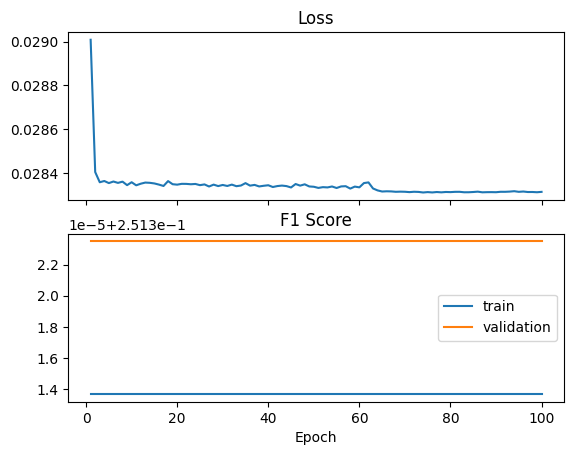

In [ ]:
plotLoss(loss_each_epoch_mlp_mean_kp, score_train_each_epoch_mlp_mean_kp, score_val_each_epoch_mlp_mean_kp)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/mlp_mean_kp.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_mean_kp)):
  if score_val_each_epoch_mlp_mean_kp[index] == max(score_val_each_epoch_mlp_mean_kp):
    n_epoch = index + 1
    break
print(n_epoch)

1


In [ ]:
mlp_mean_kp = MLP(48*48, 7, math.floor((48*48+7)/2)).to(device)
mlp_mean_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1155, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1155, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_mean_kp, score_train_each_epoch_mlp_mean_kp, score_val_each_epoch_mlp_mean_kp, optimizer_mlp_mean_kp = train_model_mlp(train_kp_loader, val_kp_loader, mlp_mean_kp, 0.001, n_epoch)

Epoch 1/1,	 Loss: 0.02909,		 F1_test: 0.25,	 F1_val: 0.25


In [ ]:
print('In the test set:', model_evaluation_mlp(test_kp_loader, mlp_mean_kp))

In the test set: 0.24714405126776262


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_mean_kp.state_dict(),
            'optimizer_state_dict': optimizer_mlp_mean_kp.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_mean_kp,
            'score_train_each_epoch': score_train_each_epoch_mlp_mean_kp,
            'score_val_each_epoch': score_val_each_epoch_mlp_mean_kp,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_mean_kp.pt')

#### Geometric Mean


##### Image

In [ ]:
mlp_geo = MLP(48*48, 7, math.floor(math.sqrt(48*48*7))).to(device)
mlp_geo

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_geo, score_train_each_epoch_mlp_geo, score_val_each_epoch_mlp_geo, optimizer_mlp_geo = train_model_mlp(train_loader, val_loader, mlp_geo, 0.0005, 100)

Epoch 1/100,	 Loss: 0.02770,		 F1_test: 0.29,	 F1_val: 0.30
Epoch 2/100,	 Loss: 0.02668,		 F1_test: 0.36,	 F1_val: 0.34
Epoch 3/100,	 Loss: 0.02630,		 F1_test: 0.34,	 F1_val: 0.32
Epoch 4/100,	 Loss: 0.02600,		 F1_test: 0.35,	 F1_val: 0.34
Epoch 5/100,	 Loss: 0.02574,		 F1_test: 0.37,	 F1_val: 0.36
Epoch 6/100,	 Loss: 0.02552,		 F1_test: 0.38,	 F1_val: 0.36
Epoch 7/100,	 Loss: 0.02534,		 F1_test: 0.39,	 F1_val: 0.37
Epoch 8/100,	 Loss: 0.02518,		 F1_test: 0.36,	 F1_val: 0.35
Epoch 9/100,	 Loss: 0.02499,		 F1_test: 0.38,	 F1_val: 0.36
Epoch 10/100,	 Loss: 0.02487,		 F1_test: 0.38,	 F1_val: 0.36
Epoch 11/100,	 Loss: 0.02468,		 F1_test: 0.39,	 F1_val: 0.37
Epoch 12/100,	 Loss: 0.02453,		 F1_test: 0.38,	 F1_val: 0.37
Epoch 13/100,	 Loss: 0.02444,		 F1_test: 0.40,	 F1_val: 0.38
Epoch 14/100,	 Loss: 0.02425,		 F1_test: 0.41,	 F1_val: 0.38
Epoch 15/100,	 Loss: 0.02414,		 F1_test: 0.41,	 F1_val: 0.36
Epoch 16/100,	 Loss: 0.02401,		 F1_test: 0.41,	 F1_val: 0.39
Epoch 17/100,	 Loss: 0.02397,		 F

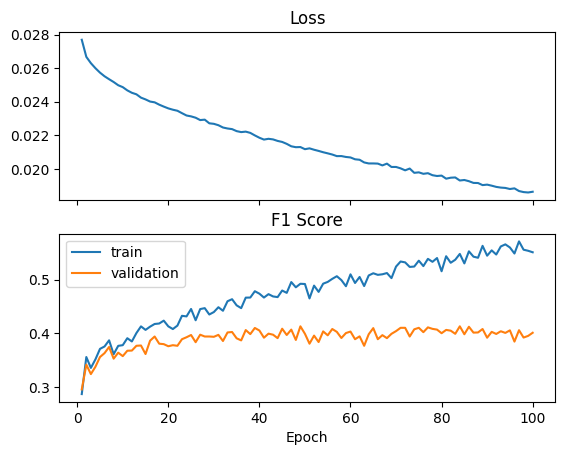

In [ ]:
plotLoss(loss_each_epoch_mlp_geo, score_train_each_epoch_mlp_geo, score_val_each_epoch_mlp_geo)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/mlp_geo_image.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_geo)):
  if score_val_each_epoch_mlp_geo[index] == max(score_val_each_epoch_mlp_geo):
    n_epoch = index + 1
    break
print(n_epoch)

49


In [ ]:
mlp_geo = MLP(48*48, 7, math.floor(math.sqrt(48*48*7))).to(device)
mlp_geo

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_geo, acc_train_each_epoch_mlp_geo, acc_val_each_epoch_mlp_geo, optimizer_mlp_geo = train_model_mlp(train_loader, val_loader, mlp_geo, 0.001, n_epoch)

Epoch 1/49,	 Loss: 0.02778,		 F1_test: 0.32,	 F1_val: 0.32
Epoch 2/49,	 Loss: 0.02664,		 F1_test: 0.35,	 F1_val: 0.33
Epoch 3/49,	 Loss: 0.02627,		 F1_test: 0.34,	 F1_val: 0.33
Epoch 4/49,	 Loss: 0.02596,		 F1_test: 0.37,	 F1_val: 0.35
Epoch 5/49,	 Loss: 0.02578,		 F1_test: 0.36,	 F1_val: 0.34
Epoch 6/49,	 Loss: 0.02558,		 F1_test: 0.37,	 F1_val: 0.35
Epoch 7/49,	 Loss: 0.02543,		 F1_test: 0.35,	 F1_val: 0.34
Epoch 8/49,	 Loss: 0.02527,		 F1_test: 0.36,	 F1_val: 0.34
Epoch 9/49,	 Loss: 0.02507,		 F1_test: 0.39,	 F1_val: 0.36
Epoch 10/49,	 Loss: 0.02491,		 F1_test: 0.38,	 F1_val: 0.37
Epoch 11/49,	 Loss: 0.02486,		 F1_test: 0.38,	 F1_val: 0.35
Epoch 12/49,	 Loss: 0.02476,		 F1_test: 0.38,	 F1_val: 0.36
Epoch 13/49,	 Loss: 0.02479,		 F1_test: 0.38,	 F1_val: 0.35
Epoch 14/49,	 Loss: 0.02463,		 F1_test: 0.38,	 F1_val: 0.36
Epoch 15/49,	 Loss: 0.02449,		 F1_test: 0.39,	 F1_val: 0.36
Epoch 16/49,	 Loss: 0.02447,		 F1_test: 0.40,	 F1_val: 0.37
Epoch 17/49,	 Loss: 0.02442,		 F1_test: 0.41,	 F1

In [ ]:
print('In the test set:', model_evaluation_mlp(test_loader, mlp_geo))

In the test set: 0.38980217330732797


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_geo.state_dict(),
            'optimizer_state_dict': optimizer_mlp_geo.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_geo,
            'score_train_each_epoch': score_train_each_epoch_mlp_geo,
            'score_val_each_epoch': score_val_each_epoch_mlp_geo,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_geo.pt')

##### HOG

In [ ]:
mlp_geo_hog = MLP(900, 7, math.floor(math.sqrt(900*7))).to(device)
mlp_geo_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=79, bias=True)
    (1): ReLU()
    (2): Linear(in_features=79, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_geo_hog, score_train_each_epoch_mlp_geo_hog, score_val_each_epoch_mlp_geo_hog, optimizer_mlp_geo_hog = train_model_mlp(train_hog_loader, val_hog_loader, mlp_geo_hog, 0.001, 100)

Epoch 1/100,	 Loss: 0.02526,		 F1_test: 0.42,	 F1_val: 0.43
Epoch 2/100,	 Loss: 0.02323,		 F1_test: 0.43,	 F1_val: 0.43
Epoch 3/100,	 Loss: 0.02269,		 F1_test: 0.44,	 F1_val: 0.44
Epoch 4/100,	 Loss: 0.02239,		 F1_test: 0.46,	 F1_val: 0.45
Epoch 5/100,	 Loss: 0.02210,		 F1_test: 0.46,	 F1_val: 0.45
Epoch 6/100,	 Loss: 0.02189,		 F1_test: 0.46,	 F1_val: 0.44
Epoch 7/100,	 Loss: 0.02168,		 F1_test: 0.46,	 F1_val: 0.45
Epoch 8/100,	 Loss: 0.02152,		 F1_test: 0.48,	 F1_val: 0.46
Epoch 9/100,	 Loss: 0.02133,		 F1_test: 0.48,	 F1_val: 0.46
Epoch 10/100,	 Loss: 0.02109,		 F1_test: 0.49,	 F1_val: 0.46
Epoch 11/100,	 Loss: 0.02097,		 F1_test: 0.49,	 F1_val: 0.46
Epoch 12/100,	 Loss: 0.02079,		 F1_test: 0.50,	 F1_val: 0.47
Epoch 13/100,	 Loss: 0.02063,		 F1_test: 0.50,	 F1_val: 0.47
Epoch 14/100,	 Loss: 0.02045,		 F1_test: 0.51,	 F1_val: 0.47
Epoch 15/100,	 Loss: 0.02028,		 F1_test: 0.51,	 F1_val: 0.47
Epoch 16/100,	 Loss: 0.02007,		 F1_test: 0.51,	 F1_val: 0.46
Epoch 17/100,	 Loss: 0.01997,		 F

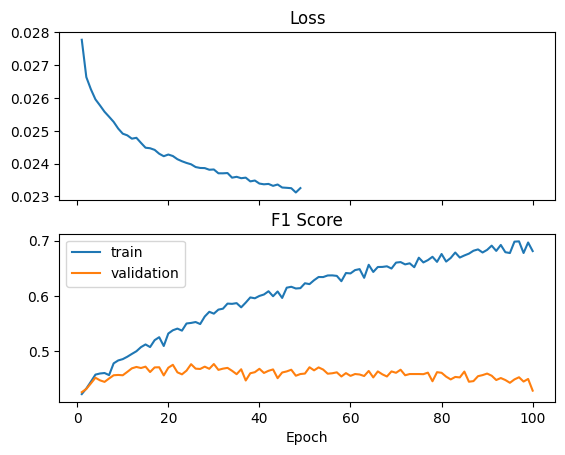

In [ ]:
plotLoss(loss_each_epoch_mlp_geo, score_train_each_epoch_mlp_geo_hog, score_val_each_epoch_mlp_geo_hog)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/mlp_geo_hog.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_geo)):
  if score_val_each_epoch_mlp_geo[index] == max(score_val_each_epoch_mlp_geo):
    n_epoch = index + 1
    break
print(n_epoch)

49


In [ ]:
loss_each_epoch_mlp_geo_hog, score_train_each_epoch_mlp_geo_hog, score_val_each_epoch_mlp_geo_hog, optimizer_mlp_geo_hog = train_model_mlp(train_hog_loader, val_hog_loader, mlp_geo_hog, 0.001, n_epoch)

Epoch 1/49,	 Loss: 0.01351,		 F1_test: 0.69,	 F1_val: 0.44
Epoch 2/49,	 Loss: 0.01348,		 F1_test: 0.69,	 F1_val: 0.45
Epoch 3/49,	 Loss: 0.01342,		 F1_test: 0.70,	 F1_val: 0.45
Epoch 4/49,	 Loss: 0.01335,		 F1_test: 0.68,	 F1_val: 0.45
Epoch 5/49,	 Loss: 0.01341,		 F1_test: 0.70,	 F1_val: 0.46
Epoch 6/49,	 Loss: 0.01331,		 F1_test: 0.70,	 F1_val: 0.45
Epoch 7/49,	 Loss: 0.01326,		 F1_test: 0.70,	 F1_val: 0.45
Epoch 8/49,	 Loss: 0.01326,		 F1_test: 0.69,	 F1_val: 0.44
Epoch 9/49,	 Loss: 0.01320,		 F1_test: 0.67,	 F1_val: 0.44
Epoch 10/49,	 Loss: 0.01319,		 F1_test: 0.70,	 F1_val: 0.44
Epoch 11/49,	 Loss: 0.01315,		 F1_test: 0.69,	 F1_val: 0.43
Epoch 12/49,	 Loss: 0.01323,		 F1_test: 0.71,	 F1_val: 0.45
Epoch 13/49,	 Loss: 0.01309,		 F1_test: 0.69,	 F1_val: 0.44
Epoch 14/49,	 Loss: 0.01303,		 F1_test: 0.69,	 F1_val: 0.44
Epoch 15/49,	 Loss: 0.01300,		 F1_test: 0.70,	 F1_val: 0.43
Epoch 16/49,	 Loss: 0.01302,		 F1_test: 0.71,	 F1_val: 0.45
Epoch 17/49,	 Loss: 0.01294,		 F1_test: 0.71,	 F1

In [ ]:
print('In the test set:', model_evaluation_mlp(test_hog_loader, mlp_geo_hog))

In the test set: 0.4446921147952076


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_geo_hog.state_dict(),
            'optimizer_state_dict': optimizer_mlp_geo_hog.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_geo_hog,
            'score_train_each_epoch': score_train_each_epoch_mlp_geo_hog,
            'score_val_each_epoch': score_val_each_epoch_mlp_geo_hog,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_geo_hog.pt')

##### Keypoint

In [ ]:
mlp_geo_kp = MLP(48*48, 7, math.floor(math.sqrt(48*48*7))).to(device)
mlp_geo_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_geo_kp, score_train_each_epoch_mlp_geo_kp, score_val_each_epoch_mlp_geo_kp, optimizer_mlp_geo_kp = train_model_mlp(train_kp_loader, val_kp_loader, mlp_geo_kp, 0.001, 100)

Epoch 1/100,	 Loss: 0.02856,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 2/100,	 Loss: 0.02839,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 3/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 4/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 5/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 6/100,	 Loss: 0.02837,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 7/100,	 Loss: 0.02839,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 8/100,	 Loss: 0.02837,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 9/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 10/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 11/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 12/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 13/100,	 Loss: 0.02834,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 14/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 15/100,	 Loss: 0.02834,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 16/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 17/100,	 Loss: 0.02836,		 F

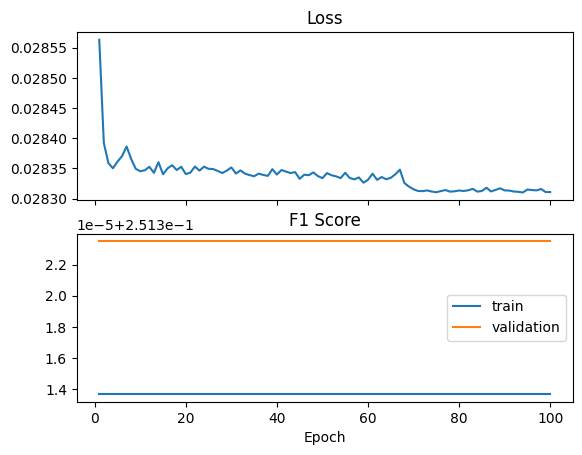

In [ ]:
plotLoss(loss_each_epoch_mlp_geo_kp, score_train_each_epoch_mlp_geo_kp, score_val_each_epoch_mlp_geo_kp)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/mlp_geo_kp.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_geo_kp)):
  if score_val_each_epoch_mlp_geo_kp[index] == max(score_val_each_epoch_mlp_geo_kp):
    n_epoch = index + 1
    break
print(n_epoch)

1


In [ ]:
mlp_geo_kp = MLP(48*48, 7, math.floor(math.sqrt(48*48*7))).to(device)
mlp_geo_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_geo_kp, score_train_each_epoch_mlp_geo_kp, score_val_each_epoch_mlp_geo_kp, optimizer_mlp_geo_kp = train_model_mlp(train_kp_loader, val_kp_loader, mlp_geo_kp, 0.001, n_epoch)

Epoch 1/1,	 Loss: 0.02858,		 F1_test: 0.25,	 F1_val: 0.25


In [ ]:
print('In the test set:', model_evaluation_mlp(test_kp_loader, mlp_geo_kp))

In the test set: 0.24714405126776262


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_geo_kp.state_dict(),
            'optimizer_state_dict': optimizer_mlp_geo_kp.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_geo_kp,
            'score_train_each_epoch': score_train_each_epoch_mlp_geo_kp,
            'score_val_each_epoch': score_val_each_epoch_mlp_geo_kp,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_geo_kp.pt')

#### Jeff Heaton's method
| Number of Hidden Layers | Result                                                                                                                                                        |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| none                    | Only capable of representing linear separable functions or decisions.                                                                                         |
| 1                       | Can approximate any function that contains a continuous mapping from one finite space to another.                                                             |
| 2                       | Can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy. |

##### Image

In [ ]:
mlp_jeff = MLP(48*48, 7, math.floor(2/3*48*48 + 7)).to(device)
mlp_jeff

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1543, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1543, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_jeff, score_train_each_epoch_mlp_jeff, score_val_each_epoch_mlp_jeff, optimizer_mlp_jeff = train_model_mlp(train_loader, val_loader, mlp_jeff, 0.001, 100)

Epoch 1/100,	 Loss: 0.02806,		 F1_test: 0.30,	 F1_val: 0.30
Epoch 2/100,	 Loss: 0.02671,		 F1_test: 0.34,	 F1_val: 0.33
Epoch 3/100,	 Loss: 0.02625,		 F1_test: 0.33,	 F1_val: 0.33
Epoch 4/100,	 Loss: 0.02594,		 F1_test: 0.36,	 F1_val: 0.35
Epoch 5/100,	 Loss: 0.02564,		 F1_test: 0.37,	 F1_val: 0.35
Epoch 6/100,	 Loss: 0.02539,		 F1_test: 0.36,	 F1_val: 0.35
Epoch 7/100,	 Loss: 0.02518,		 F1_test: 0.37,	 F1_val: 0.35
Epoch 8/100,	 Loss: 0.02497,		 F1_test: 0.38,	 F1_val: 0.37
Epoch 9/100,	 Loss: 0.02481,		 F1_test: 0.40,	 F1_val: 0.37
Epoch 10/100,	 Loss: 0.02461,		 F1_test: 0.40,	 F1_val: 0.37
Epoch 11/100,	 Loss: 0.02452,		 F1_test: 0.41,	 F1_val: 0.39
Epoch 12/100,	 Loss: 0.02428,		 F1_test: 0.40,	 F1_val: 0.37
Epoch 13/100,	 Loss: 0.02425,		 F1_test: 0.40,	 F1_val: 0.38
Epoch 14/100,	 Loss: 0.02396,		 F1_test: 0.40,	 F1_val: 0.36
Epoch 15/100,	 Loss: 0.02386,		 F1_test: 0.41,	 F1_val: 0.38
Epoch 16/100,	 Loss: 0.02376,		 F1_test: 0.41,	 F1_val: 0.37
Epoch 17/100,	 Loss: 0.02365,		 F

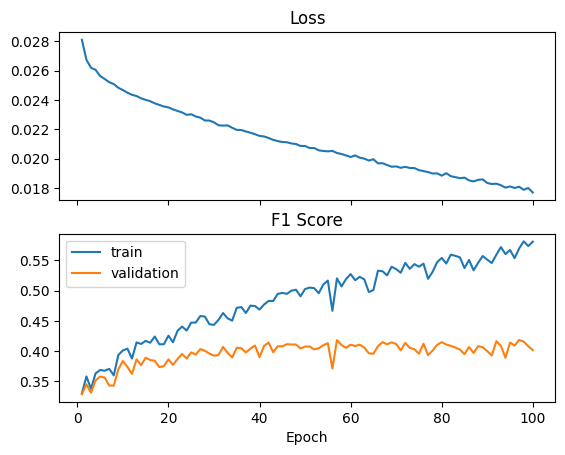

In [ ]:
plotLoss(loss_each_epoch_mlp_jeff, score_train_each_epoch_mlp_jeff, score_val_each_epoch_mlp_jeff)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/5.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_jeff)):
  if score_val_each_epoch_mlp_jeff[index] == max(score_val_each_epoch_mlp_jeff):
    n_epoch = index + 1
    break
print(n_epoch)

97


In [ ]:
mlp_jeff = MLP(48*48, 7, math.floor(2/3*48*48 + 7)).to(device)
mlp_jeff

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1543, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1543, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_jeff, score_train_each_epoch_mlp_jeff, score_val_each_epoch_mlp_jeff, optimizer_mlp_jeff = train_model_mlp(train_loader, val_loader, mlp_jeff, 0.001, n_epoch)

Epoch 1/97,	 Loss: 0.01703,		 F1_test: 0.60,	 F1_val: 0.39
Epoch 2/97,	 Loss: 0.01684,		 F1_test: 0.59,	 F1_val: 0.39
Epoch 3/97,	 Loss: 0.01675,		 F1_test: 0.59,	 F1_val: 0.40
Epoch 4/97,	 Loss: 0.01681,		 F1_test: 0.59,	 F1_val: 0.40
Epoch 5/97,	 Loss: 0.01671,		 F1_test: 0.60,	 F1_val: 0.38
Epoch 6/97,	 Loss: 0.01669,		 F1_test: 0.60,	 F1_val: 0.41
Epoch 7/97,	 Loss: 0.01661,		 F1_test: 0.61,	 F1_val: 0.39
Epoch 8/97,	 Loss: 0.01663,		 F1_test: 0.58,	 F1_val: 0.38
Epoch 9/97,	 Loss: 0.01680,		 F1_test: 0.62,	 F1_val: 0.40
Epoch 10/97,	 Loss: 0.01675,		 F1_test: 0.59,	 F1_val: 0.38
Epoch 11/97,	 Loss: 0.01645,		 F1_test: 0.59,	 F1_val: 0.39
Epoch 12/97,	 Loss: 0.01650,		 F1_test: 0.60,	 F1_val: 0.39
Epoch 13/97,	 Loss: 0.01651,		 F1_test: 0.62,	 F1_val: 0.39
Epoch 14/97,	 Loss: 0.01629,		 F1_test: 0.61,	 F1_val: 0.39
Epoch 15/97,	 Loss: 0.01620,		 F1_test: 0.60,	 F1_val: 0.39
Epoch 16/97,	 Loss: 0.01624,		 F1_test: 0.61,	 F1_val: 0.39
Epoch 17/97,	 Loss: 0.01603,		 F1_test: 0.64,	 F1

In [ ]:
print('In the test set:', model_evaluation_mlp(test_loader, mlp_jeff))

In the test set: 0.39955419336862635


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_jeff.state_dict(),
            'optimizer_state_dict': optimizer_mlp_jeff.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_jeff,
            'score_train_each_epoch': score_train_each_epoch_mlp_jeff,
            'score_val_each_epoch': score_val_each_epoch_mlp_jeff,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_jeff.pt')

##### HOG

In [ ]:
mlp_jeff_hog = MLP(900, 7, math.floor(2/3*900 + 7)).to(device)
mlp_jeff_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=607, bias=True)
    (1): ReLU()
    (2): Linear(in_features=607, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_jeff_hog, score_train_each_epoch_mlp_jeff_hog, score_val_each_epoch_mlp_jeff_hog, optimizer_mlp_jeff_hog = train_model_mlp(train_hog_loader, val_hog_loader, mlp_jeff_hog, 0.001, 100)

Epoch 1/100,	 Loss: 0.02464,		 F1_test: 0.42,	 F1_val: 0.42
Epoch 2/100,	 Loss: 0.02281,		 F1_test: 0.45,	 F1_val: 0.45
Epoch 3/100,	 Loss: 0.02223,		 F1_test: 0.44,	 F1_val: 0.43
Epoch 4/100,	 Loss: 0.02179,		 F1_test: 0.47,	 F1_val: 0.45
Epoch 5/100,	 Loss: 0.02135,		 F1_test: 0.48,	 F1_val: 0.46
Epoch 6/100,	 Loss: 0.02083,		 F1_test: 0.51,	 F1_val: 0.47
Epoch 7/100,	 Loss: 0.02042,		 F1_test: 0.51,	 F1_val: 0.46
Epoch 8/100,	 Loss: 0.01991,		 F1_test: 0.53,	 F1_val: 0.48
Epoch 9/100,	 Loss: 0.01937,		 F1_test: 0.55,	 F1_val: 0.48
Epoch 10/100,	 Loss: 0.01887,		 F1_test: 0.56,	 F1_val: 0.48
Epoch 11/100,	 Loss: 0.01828,		 F1_test: 0.58,	 F1_val: 0.49
Epoch 12/100,	 Loss: 0.01775,		 F1_test: 0.59,	 F1_val: 0.48
Epoch 13/100,	 Loss: 0.01722,		 F1_test: 0.58,	 F1_val: 0.48
Epoch 14/100,	 Loss: 0.01673,		 F1_test: 0.64,	 F1_val: 0.50
Epoch 15/100,	 Loss: 0.01611,		 F1_test: 0.65,	 F1_val: 0.49
Epoch 16/100,	 Loss: 0.01558,		 F1_test: 0.66,	 F1_val: 0.50
Epoch 17/100,	 Loss: 0.01505,		 F

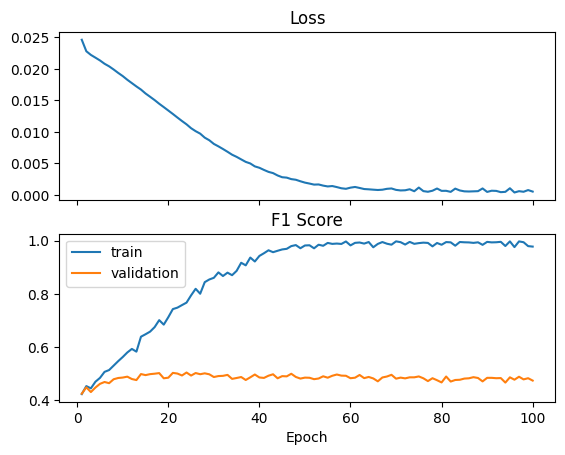

In [ ]:
plotLoss(loss_each_epoch_mlp_jeff_hog, score_train_each_epoch_mlp_jeff_hog, score_val_each_epoch_mlp_jeff_hog)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/6.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_jeff_hog)):
  if score_val_each_epoch_mlp_jeff_hog[index] == max(score_val_each_epoch_mlp_jeff_hog):
    n_epoch = index + 1
    break
print(n_epoch)

24


In [ ]:
mlp_jeff_hog = MLP(900, 7, math.floor(2/3*900 + 7)).to(device)
mlp_jeff_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=607, bias=True)
    (1): ReLU()
    (2): Linear(in_features=607, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_jeff_hog, score_train_each_epoch_mlp_jeff_hog, score_val_each_epoch_mlp_jeff_hog, optimizer_mlp_jeff_hog = train_model_mlp(train_hog_loader, val_hog_loader, mlp_jeff_hog, 0.001, n_epoch)

Epoch 1/24,	 Loss: 0.02447,		 F1_test: 0.42,	 F1_val: 0.42
Epoch 2/24,	 Loss: 0.02278,		 F1_test: 0.44,	 F1_val: 0.43
Epoch 3/24,	 Loss: 0.02211,		 F1_test: 0.46,	 F1_val: 0.45
Epoch 4/24,	 Loss: 0.02175,		 F1_test: 0.48,	 F1_val: 0.46
Epoch 5/24,	 Loss: 0.02122,		 F1_test: 0.49,	 F1_val: 0.46
Epoch 6/24,	 Loss: 0.02072,		 F1_test: 0.50,	 F1_val: 0.46
Epoch 7/24,	 Loss: 0.02019,		 F1_test: 0.52,	 F1_val: 0.48
Epoch 8/24,	 Loss: 0.01968,		 F1_test: 0.53,	 F1_val: 0.47
Epoch 9/24,	 Loss: 0.01920,		 F1_test: 0.56,	 F1_val: 0.48
Epoch 10/24,	 Loss: 0.01857,		 F1_test: 0.57,	 F1_val: 0.48
Epoch 11/24,	 Loss: 0.01801,		 F1_test: 0.60,	 F1_val: 0.49
Epoch 12/24,	 Loss: 0.01743,		 F1_test: 0.60,	 F1_val: 0.49
Epoch 13/24,	 Loss: 0.01693,		 F1_test: 0.61,	 F1_val: 0.48
Epoch 14/24,	 Loss: 0.01633,		 F1_test: 0.64,	 F1_val: 0.50
Epoch 15/24,	 Loss: 0.01573,		 F1_test: 0.67,	 F1_val: 0.50
Epoch 16/24,	 Loss: 0.01501,		 F1_test: 0.65,	 F1_val: 0.51
Epoch 17/24,	 Loss: 0.01449,		 F1_test: 0.69,	 F1

In [ ]:
print('In the test set:', model_evaluation_mlp(test_hog_loader, mlp_jeff_hog))

In the test set: 0.5103092783505154


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_jeff_hog.state_dict(),
            'optimizer_state_dict': optimizer_mlp_jeff_hog.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_jeff_hog,
            'score_train_each_epoch': score_train_each_epoch_mlp_jeff_hog,
            'score_val_each_epoch': score_val_each_epoch_mlp_jeff_hog,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_jeff_hog.pt')

##### Keypoint

In [ ]:
mlp_jeff_kp = MLP(48*48, 7, math.floor(2/3*48*48 + 7)).to(device)
mlp_jeff_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1543, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1543, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_jeff_kp, score_train_each_epoch_mlp_jeff_kp, score_val_each_epoch_mlp_jeff_kp, optimizer_mlp_jeff_kp = train_model_mlp(train_kp_loader, val_kp_loader, mlp_jeff_kp, 0.001, 100)

Epoch 1/100,	 Loss: 0.02911,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 2/100,	 Loss: 0.02841,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 3/100,	 Loss: 0.02839,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 4/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 5/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 6/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 7/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 8/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 9/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 10/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 11/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 12/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 13/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 14/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 15/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 16/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 17/100,	 Loss: 0.02834,		 F

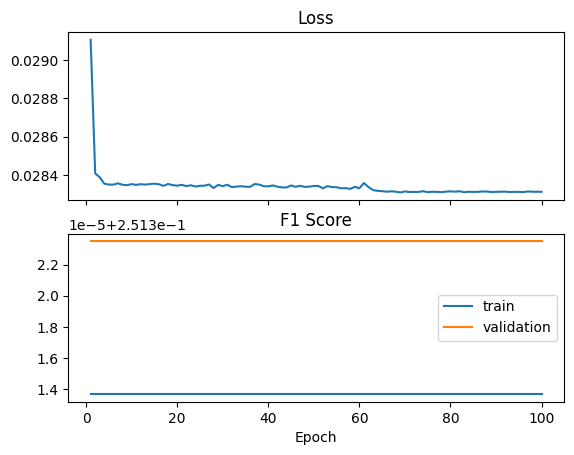

In [ ]:
plotLoss(loss_each_epoch_mlp_jeff_kp, score_train_each_epoch_mlp_jeff_kp, score_val_each_epoch_mlp_jeff_kp)
plt.savefig('/content/drive/MyDrive/PYTHON/CV/DoAn/image/mlp_jeff_kp.png')

In [ ]:
n_epoch = 0
for index in range(len(score_val_each_epoch_mlp_jeff_kp)):
  if score_val_each_epoch_mlp_jeff_kp[index] == max(score_val_each_epoch_mlp_jeff_kp):
    n_epoch = index + 1
    break
print(n_epoch)

1


In [ ]:
mlp_jeff_kp = MLP(48*48, 7, math.floor(2/3*48*48 + 7)).to(device)
mlp_jeff_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1543, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1543, out_features=7, bias=True)
  )
)

In [ ]:
loss_each_epoch_mlp_jeff_kp, score_train_each_epoch_mlp_jeff_kp, score_val_each_epoch_mlp_jeff_kp, optimizer_mlp_jeff_kp = train_model_mlp(train_kp_loader, val_kp_loader, mlp_jeff_kp, 0.001, 100)

Epoch 1/100,	 Loss: 0.02913,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 2/100,	 Loss: 0.02839,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 3/100,	 Loss: 0.02837,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 4/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 5/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 6/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 7/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 8/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 9/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 10/100,	 Loss: 0.02834,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 11/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 12/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 13/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 14/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 15/100,	 Loss: 0.02836,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 16/100,	 Loss: 0.02835,		 F1_test: 0.25,	 F1_val: 0.25
Epoch 17/100,	 Loss: 0.02835,		 F

In [ ]:
print('In the test set:', model_evaluation_mlp(test_kp_loader, mlp_jeff_kp))

In the test set: 0.24714405126776262


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': mlp_jeff_kp.state_dict(),
            'optimizer_state_dict': optimizer_mlp_jeff_kp.state_dict(),
            'loss_each_epoch': loss_each_epoch_mlp_jeff_kp,
            'score_train_each_epoch': score_train_each_epoch_mlp_jeff_kp,
            'score_val_each_epoch': score_val_each_epoch_mlp_jeff_kp,
            }, '/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_jeff_kp.pt')